In [1]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader as GDataLoader, Batch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv, global_max_pool
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT, \
MatchingAttention, getDataLoaderAndLabels,GCNWithSkipConnections
from model import DATASET_PATH
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
from sklearn.metrics import classification_report
from model import FCClassifier, MyNetwork, DATASET_PATH, MatchingAttention, RGCNWithGAT, \
RGATWithSkipConnections, EdgeGATWithSkipConnection, EGATConv, EdgeGATWithGCN, EdgeGATWithSkipConnection,\
GCNWithConcatenation, GATWithBatchNormAndDropout
%load_ext autoreload
%autoreload 2

In [2]:
key=True
WINDOW_SIZE = 10

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [3]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

In [4]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [5]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [6]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= WINDOW_SIZE) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [7]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [8]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [9]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [10]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [11]:
file_path1 = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [12]:
# print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

In [13]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

In [14]:
len(edgeIndicesDev[0][0])

21

#### Train without relational features

In [15]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_dev = pickle.load(file)
y_dev = torch.tensor(y_dev)

In [16]:
y_tensor_train = [y_train[start:end + 1] for start, end in rangesTrain]
y_tensor_dev = [y_dev[start:end + 1] for start, end in rangesDev]
y_tensor_test = [y_test[start:end + 1] for start, end in rangesTest]

In [17]:
def getDataset(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
    dataset=[]
    for X, edges, Y, edgeTypes in zip(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
        graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long),
            y=torch.tensor(Y, dtype=torch.long),
            edge_type = torch.tensor(edgeTypes, dtype=torch.long)
        )
        dataset.append(graph_data)
    return dataset

train_dataset = getDataset(contextualEmbeddingsTrain, edgeIndicesTrain, y_tensor_train, edgeTypesTrain)
dev_dataset = getDataset(contextualEmbeddingsDev, edgeIndicesDev, y_tensor_dev, edgeTypesDev)
test_dataset = getDataset(contextualEmbeddingsTest, edgeIndicesTest, y_tensor_test, edgeTypesTest)

train_loader = GDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = GDataLoader(dev_dataset, batch_size=1, shuffle=True)
test_loader = GDataLoader(test_dataset, batch_size=1, shuffle=True)

C:\Users\edayo\AppData\Local\Temp\ipykernel_21856\3524950887.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
C:\Users\edayo\AppData\Local\Temp\ipykernel_21856\3524950887.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edges, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_21856\3524950887.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(Y, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_21856\3524950887.py:8: UserWarning: 

In [18]:
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)
    
label_decoder.values()

dict_values(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [19]:
def train_model(model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stop_threshold = 0.0001
    best_val_loss = float('inf')
    no_improve_epochs = 0
    max_no_improve_epochs = 5

    for epoch in range(25):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:04<00:00, 187.74it/s]


Epoch 1: Train Loss = 1.5556028033880627, Val Loss = 1.567800412687023, Train Acc = 0.5091271158313972, Val Acc = 0.5


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 174.51it/s]


Epoch 2: Train Loss = 1.4783497850384264, Val Loss = 1.6886598509684037, Train Acc = 0.53667441088616, Val Acc = 0.5356371490280778


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 176.00it/s]


Epoch 3: Train Loss = 1.4305240991068822, Val Loss = 1.9503696135590585, Train Acc = 0.552826640115057, Val Acc = 0.47840172786177104


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 172.01it/s]


Epoch 4: Train Loss = 1.4386292663859386, Val Loss = 1.6911977959817714, Train Acc = 0.5436442084301361, Val Acc = 0.5032397408207343


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 173.85it/s]


Epoch 5: Train Loss = 1.4113385395303142, Val Loss = 1.403571905045027, Train Acc = 0.5584688571744661, Val Acc = 0.5388768898488121


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:06<00:00, 150.08it/s]


Epoch 6: Train Loss = 1.4166135610505322, Val Loss = 1.5108173181501667, Train Acc = 0.5643323376479699, Val Acc = 0.4535637149028078


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 172.74it/s]


Epoch 7: Train Loss = 1.404874547843239, Val Loss = 1.612655313497179, Train Acc = 0.5643323376479699, Val Acc = 0.5377969762419006


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 171.33it/s]


Epoch 8: Train Loss = 1.3618439019968112, Val Loss = 1.6354987473970048, Train Acc = 0.5713021351919461, Val Acc = 0.5226781857451404


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 171.43it/s]


Epoch 9: Train Loss = 1.3082867778862028, Val Loss = 2.1875442829024925, Train Acc = 0.5853523619869455, Val Acc = 0.36825053995680346


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████| 918/918 [00:05<00:00, 171.50it/s]


Epoch 10: Train Loss = 1.4025775607967494, Val Loss = 1.5056887280740094, Train Acc = 0.5716340303130877, Val Acc = 0.5205183585313174
Early stopping triggered


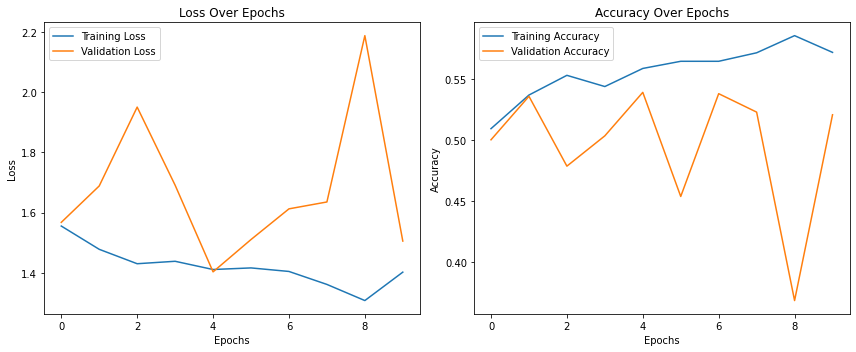

              precision    recall  f1-score   support

       anger       0.58      0.23      0.33       400
     disgust       0.11      0.21      0.14        63
        fear       0.00      0.00      0.00        43
         joy       0.39      0.51      0.44       321
     neutral       0.69      0.82      0.75      1095
     sadness       0.31      0.08      0.13       200
    surprise       0.44      0.58      0.50       248

    accuracy                           0.56      2370
   macro avg       0.36      0.35      0.33      2370
weighted avg       0.55      0.56      0.53      2370



In [20]:
model = GCNWithSkipConnections(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_model(model, test_loader)

In [21]:
# model = GCNWithSkipConnections(num_features=768, num_classes=7)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# early_stop_threshold = 0.0001
# best_val_loss = float('inf')
# no_improve_epochs = 0
# max_no_improve_epochs = 5

# for epoch in range(25):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
    
#     for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         preds = out.argmax(dim=1)
#         correct_train += (preds == data.y).sum().item()
#         total_train += data.y.size(0)
    
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(correct_train / total_train)
    
#     model.eval()
#     val_loss = 0
#     correct_val = 0
#     total_val = 0
    
#     with torch.no_grad():
#         for data in val_loader:
#             out = model(data.x, data.edge_index)
#             loss = criterion(out, data.y)
#             val_loss += loss.item()
            
#             preds = out.argmax(dim=1)
#             correct_val += (preds == data.y).sum().item()
#             total_val += data.y.size(0)
    
#     val_losses.append(val_loss / len(val_loader))
#     val_accuracies.append(correct_val / total_val)
    
#     print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")
    
#     if best_val_loss - val_losses[-1] < early_stop_threshold:
#         no_improve_epochs += 1
#         if no_improve_epochs >= max_no_improve_epochs:
#             print("Early stopping triggered")
#             break
#     else:
#         no_improve_epochs = 0
#         best_val_loss = val_losses[-1]

In [22]:
# # Plot learning curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.tight_layout()
# plt.show()

In [23]:
# # Classification report on test set
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         preds = out.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(data.y.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

#### RGCN

In [24]:
def train_relational_model(model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stop_threshold = 0.0001
    best_val_loss = float('inf')
    no_improve_epochs = 0
    max_no_improve_epochs = 5

    for epoch in range(25):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index , data.edge_type)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.edge_type)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_relation_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

In [25]:
model

GCNWithSkipConnections(
  (conv1): GCNConv(768, 64)
  (conv2): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=7, bias=True)
  (skip_transform): Linear(in_features=768, out_features=64, bias=True)
)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:07<00:00, 126.46it/s]


Epoch 1: Train Loss = 1.5820789765282524, Val Loss = 1.638897329568863, Train Acc = 0.5110078548512004, Val Acc = 0.49892008639308855


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 99.83it/s]


Epoch 2: Train Loss = 1.4655979268723582, Val Loss = 1.566103260671155, Train Acc = 0.5351255669874986, Val Acc = 0.5356371490280778


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 99.12it/s]


Epoch 3: Train Loss = 1.4788353201935234, Val Loss = 2.159569626108984, Train Acc = 0.5512777962163956, Val Acc = 0.3898488120950324


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 98.24it/s]


Epoch 4: Train Loss = 1.4118119368617765, Val Loss = 1.6000868503967027, Train Acc = 0.5581369620533245, Val Acc = 0.4924406047516199


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 98.20it/s]


Epoch 5: Train Loss = 1.417943983965742, Val Loss = 1.5552507255519374, Train Acc = 0.5569200132758049, Val Acc = 0.5161987041036717


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 94.10it/s]


Epoch 6: Train Loss = 1.4733261714663057, Val Loss = 1.882528549499726, Train Acc = 0.550503374267065, Val Acc = 0.43088552915766737


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 95.66it/s]


Epoch 7: Train Loss = 1.4500552188541156, Val Loss = 1.5473268557800335, Train Acc = 0.5695320278791902, Val Acc = 0.5118790496760259


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 93.95it/s]


Epoch 8: Train Loss = 1.3406182359062004, Val Loss = 1.68295303221499, Train Acc = 0.5770549839584025, Val Acc = 0.5129589632829373


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:11<00:00, 79.74it/s]


Epoch 9: Train Loss = 1.382010349865865, Val Loss = 1.6783678330732195, Train Acc = 0.5729616107976546, Val Acc = 0.509719222462203


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 92.49it/s]


Epoch 10: Train Loss = 1.3319522799084, Val Loss = 1.72808869936493, Train Acc = 0.5770549839584025, Val Acc = 0.5259179265658748


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:09<00:00, 92.36it/s]


Epoch 11: Train Loss = 1.3112137247980744, Val Loss = 1.7111440143558416, Train Acc = 0.5865693107644651, Val Acc = 0.5539956803455723


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [00:10<00:00, 89.79it/s]


Epoch 12: Train Loss = 1.3889449778416707, Val Loss = 1.7354404393876537, Train Acc = 0.576833720544308, Val Acc = 0.48488120950323976
Early stopping triggered


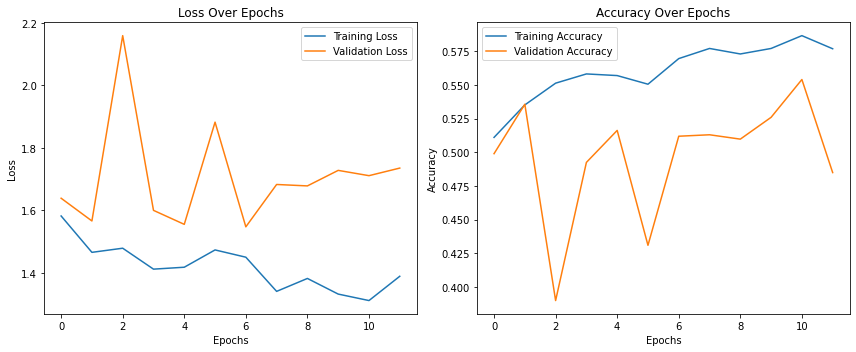

              precision    recall  f1-score   support

       anger       0.51      0.19      0.28       400
     disgust       0.14      0.02      0.03        63
        fear       0.15      0.12      0.13        43
         joy       0.26      0.75      0.39       321
     neutral       0.73      0.70      0.71      1095
     sadness       0.23      0.05      0.08       200
    surprise       0.54      0.34      0.42       248

    accuracy                           0.50      2370
   macro avg       0.37      0.31      0.29      2370
weighted avg       0.54      0.50      0.48      2370



In [26]:
model = RGCNWithGAT(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

#### RGAT

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:22<00:00,  6.43it/s]


Epoch 1: Train Loss = 120.53008984876614, Val Loss = 371.36553132132195, Train Acc = 0.2781281115167607, Val Acc = 0.3952483801295896


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:20<00:00,  6.51it/s]


Epoch 2: Train Loss = 324.3057649514774, Val Loss = 166.75151959965737, Train Acc = 0.28266401150569753, Val Acc = 0.38120950323974084


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:18<00:00,  6.62it/s]


Epoch 3: Train Loss = 164.63007276042615, Val Loss = 44.48933245794157, Train Acc = 0.3139727846000664, Val Acc = 0.39092872570194387


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:17<00:00,  6.66it/s]


Epoch 4: Train Loss = 123.83465732286699, Val Loss = 71.51875441261892, Train Acc = 0.3282442748091603, Val Acc = 0.4017278617710583


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:30<00:00,  6.12it/s]


Epoch 5: Train Loss = 100.01461393874715, Val Loss = 40.780879802918165, Train Acc = 0.34815798207766346, Val Acc = 0.4352051835853132


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:14<00:00,  6.83it/s]


Epoch 6: Train Loss = 214.258141988373, Val Loss = 44.86905249584927, Train Acc = 0.31861931629605045, Val Acc = 0.4373650107991361


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:12<00:00,  6.90it/s]


Epoch 7: Train Loss = 138.78333012267646, Val Loss = 120.51242693354574, Train Acc = 0.33941807722093154, Val Acc = 0.41252699784017277


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:11<00:00,  6.96it/s]


Epoch 8: Train Loss = 165.23654282903377, Val Loss = 105.24272468652617, Train Acc = 0.33078880407124683, Val Acc = 0.4006479481641469


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [02:16<00:00,  6.74it/s]


Epoch 9: Train Loss = 233.51575376395306, Val Loss = 205.9822907179929, Train Acc = 0.3384223918575064, Val Acc = 0.3693304535637149


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████| 918/918 [02:06<00:00,  7.27it/s]


Epoch 10: Train Loss = 428.1450193198418, Val Loss = 366.7919337026189, Train Acc = 0.32724858944573515, Val Acc = 0.3714902807775378
Early stopping triggered


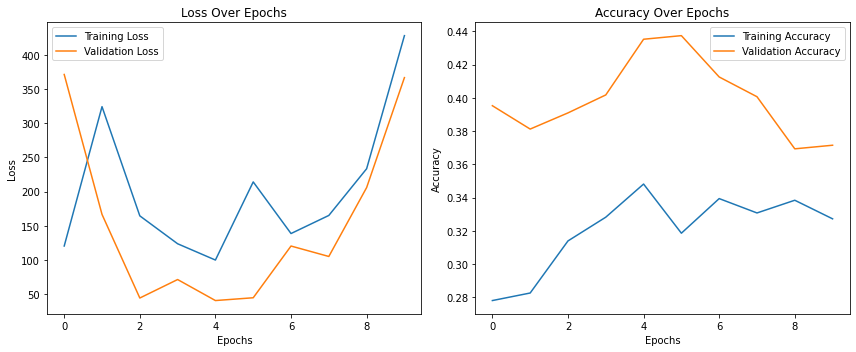

              precision    recall  f1-score   support

       anger       0.48      0.06      0.10       400
     disgust       0.00      0.00      0.00        63
        fear       0.00      0.00      0.00        43
         joy       0.19      0.15      0.16       321
     neutral       0.50      0.81      0.62      1095
     sadness       0.13      0.04      0.06       200
    surprise       0.30      0.28      0.29       248

    accuracy                           0.44      2370
   macro avg       0.23      0.19      0.18      2370
weighted avg       0.38      0.44      0.36      2370



In [28]:
model = RGATWithSkipConnections(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

#### EdgeGAT

In [29]:
DIOLOG_ID = 0
startIdx, endIdx = rangesTrain[DIOLOG_ID][0], rangesTrain[DIOLOG_ID][1]

graph = dgl.graph((edgeIndicesTrain[DIOLOG_ID][0], edgeIndicesTrain[DIOLOG_ID][1]))
edge_feats = get_ohe(edgeTypesTrain[DIOLOG_ID])

# egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)

In [30]:
graph

Graph(num_nodes=14, num_edges=99,
      ndata_schemes={}
      edata_schemes={})

In [31]:
class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out
            
class EdgeGATWithSkipConnection(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithSkipConnection, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        # Add self-loops to edge_index and adjust edge_attr accordingly if needed
#         print(f"nfeats shape: {nfeats.shape}")
        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
#         print(f"X shape: {x.shape}")
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
#         print(x.shape, " vs ", x_skip.shape)
        x += x_skip  # Add skip connection
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [32]:
def train_egat_model(model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stop_threshold = 0.0001
    best_val_loss = float('inf')
    no_improve_epochs = 0
    max_no_improve_epochs = 5

    for epoch in range(25):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x, edge_feats)
#             print(f"out shape: {out.shape}")
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out = model(graph, data.x , edge_feats)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_egat_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x , edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:13<00:00, 68.72it/s]


Epoch 1: Train Loss = 1.5669119041210167, Val Loss = 1.502329335453805, Train Acc = 0.5076889036397831, Val Acc = 0.49136069114470843


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:14<00:00, 62.11it/s]


Epoch 2: Train Loss = 1.7553673818348456, Val Loss = 1.4256051142563981, Train Acc = 0.5260537670096249, Val Acc = 0.5248380129589633


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:16<00:00, 55.57it/s]


Epoch 3: Train Loss = 1.366678566600892, Val Loss = 1.4766369286213028, Train Acc = 0.5564774864476159, Val Acc = 0.5637149028077754


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:16<00:00, 57.19it/s]


Epoch 4: Train Loss = 1.4400951921663903, Val Loss = 1.3632660310589866, Train Acc = 0.5497289523177342, Val Acc = 0.5464362850971922


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:16<00:00, 55.07it/s]


Epoch 5: Train Loss = 1.3863080476161116, Val Loss = 1.5663301387194837, Train Acc = 0.5594645425378914, Val Acc = 0.5539956803455723


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:15<00:00, 58.20it/s]


Epoch 6: Train Loss = 1.3982720519202987, Val Loss = 1.5746824105134172, Train Acc = 0.5693107644650957, Val Acc = 0.49676025917926564


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:16<00:00, 57.19it/s]


Epoch 7: Train Loss = 1.3707230990480688, Val Loss = 1.760345577189092, Train Acc = 0.5680938156875761, Val Acc = 0.5064794816414687


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:15<00:00, 57.90it/s]


Epoch 8: Train Loss = 1.418812737071761, Val Loss = 1.6695617584699995, Train Acc = 0.5726297156765129, Val Acc = 0.43628509719222464


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:16<00:00, 57.24it/s]


Epoch 9: Train Loss = 1.343149446924917, Val Loss = 1.9076472952794492, Train Acc = 0.5792676180993472, Val Acc = 0.5399568034557235
Early stopping triggered


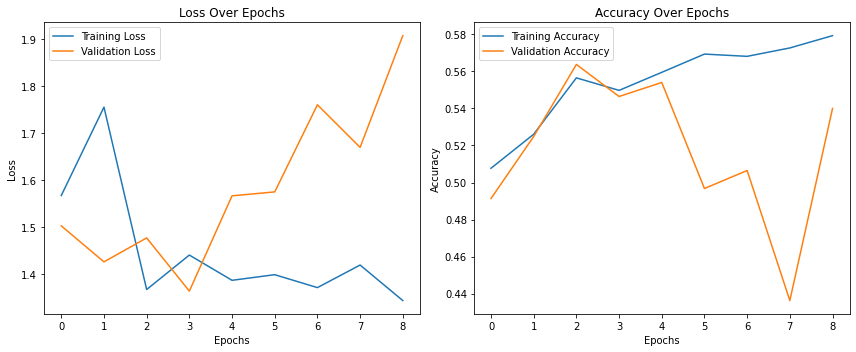

              precision    recall  f1-score   support

       anger       0.52      0.47      0.49       400
     disgust       0.67      0.03      0.06        63
        fear       0.21      0.16      0.18        43
         joy       0.48      0.39      0.43       321
     neutral       0.64      0.93      0.76      1095
     sadness       0.00      0.00      0.00       200
    surprise       0.65      0.33      0.44       248

    accuracy                           0.60      2370
   macro avg       0.45      0.33      0.34      2370
weighted avg       0.54      0.60      0.54      2370



In [33]:
model = EdgeGATWithSkipConnection(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
# model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_egat_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_egat_model(model, test_loader)

<h4> Creating "SAMPLE" graph features based on various graph networks

In [100]:
model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)

In [ ]:
# len(rangesTrain)

Start of sample

<h5>DGCN

In [ ]:
class SampleDataset(Dataset):
    def __init__(self):
        self.features = [torch.rand(14, 200)]
        self.edge_index = [torch.randint(0, 14, (2, 69))]
        self.edge_type = [torch.randint(0, 4, (69,))]
        self.edge_index_lengths = [torch.tensor([69])]
        self.umask = [torch.randint(0, 2, (1, 14))]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (self.features[idx], self.edge_index[idx], self.edge_type[idx], self.edge_index_lengths[idx], self.umask[idx])

# Create the dataset and dataloader
dataset = SampleDataset()
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# features = torch.randn(14, 200)
# edge_index = [torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
#                             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]])]
# edge_type = [torch.tensor([1, 0, 2, 2, 2, 0, 1, 3, 2, 2, 0, 2, 2, 2])]
# seq_lengths  = torch.tensor([[14]])
# umask = torch.ones(1, 1, 14)

# nodal_attn = False
# avec = False

# # Initialize the model
# model = GraphNetwork_RGCN(num_features=200, num_classes=7, num_relations=4, max_seq_len=14)
# gcn_representation = model(features, edge_index, edge_type)
# print("GCN Representation Shape:", gcn_representation.shape)

In [ ]:
# features[0].shape

<h5>GAT w/o edge feats

In [ ]:
# # Example usage:
# num_features = 768
# num_classes = 7
# num_relations = 4  # This parameter is not used with GATConv but kept for compatibility
# max_seq_len = 14
# hidden_size = 64
# num_heads = 8
# dropout = 0.5
# no_cuda = False

# model = GraphNetwork_GAT(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)

# # Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = [torch.randint(0, 14, (2, 20))]  # Example edge index with 20 edges
# # edge_type = [torch.randint(0, num_relations, (20,))]  # Example edge types

# # Forward pass
# out = model(x, edge_index)
# print("Output shape:", out.shape)

<h5>GAT with edge feats

In [ ]:
# num_features = 768
# num_classes = 7
# num_relations = 4  # Assuming edge features have 4 dimensions
# max_seq_len = 14
# hidden_size = 64
# num_heads = 8
# dropout = 0.5
# no_cuda = False

# model = GraphNetwork_GAT_EdgeFeat(num_features, num_classes, num_relations, max_seq_len,
#                                   hidden_size, num_heads, dropout)

# # Dummy inputs for testing
# x = torch.randn((14, num_features))
# edge_index = [torch.randint(0, 14, (2, 20))]
# edge_attr = [torch.randn((20, num_relations))]

# # Forward pass
# out = model(x, edge_index, edge_attr)
# print("Output shape:", out.shape)

In [ ]:
# edge_attr = torch.randint(0, 2, (20, 1)).float()  # Example binary edge features
# edge_attr

<h5>GATv2 w/o edgetype

In [ ]:
# num_features = 768
# num_classes = 7
# hidden_size = 64
# num_heads = 8
# dropout = 0.5
# no_cuda = False

# model = GraphNetwork_GATv2(num_features, num_classes, hidden_size, num_heads, dropout)

# # Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_attr = torch.randn((20, 1))  # Example edge features

# # Forward pass
# out = model(x, edge_index, edge_attr)
# print("Output shape:", out.shape)

# # Forward pass with attention weights
# out, (edge_index, attention_weights) = model(x, edge_index, edge_attr, return_attention_weights=True)
# print("Output shape with attention:", out.shape)
# print("Attention weights shape:", attention_weights.shape)

<h5>GATv2 with edge type

In [ ]:
# num_features = 768
# num_classes = 7
# num_relations = 4
# max_seq_len = 30
# hidden_size = 64
# num_heads = 8
# dropout = 0.5
# no_cuda = False

# model = GraphNetwork_GATv2_EdgeFeat(num_features, num_classes, num_relations,
#                                     max_seq_len, hidden_size, num_heads, dropout)

# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_attr = torch.randn((20, num_relations))  # Example edge features

# # Forward pass
# out = model(x, edge_index, edge_attr)
# print("Output shape:", out.shape)

<h5>RGAT

In [ ]:
# edge_index

In [ ]:
# num_features = 768
# num_classes = 7
# num_relations = 3  # Example number of relations
# hidden_size = 64
# num_heads = 8
# dropout = 0.5
# edge_dim = 1  # Dimensionality of edge attributes
# no_cuda = False


# model = GraphNetwork_RGAT(num_features, num_classes, num_relations, hidden_size, num_heads, dropout, 
#                           edge_dim)

# # Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_type = torch.randint(0, num_relations, (20,))  # Example edge types
# edge_attr = torch.randn((20, 1))  # Example edge features

# # Forward pass
# out = model(x, edge_index, edge_type=edge_type)
# print("Output shape:", out.shape)

End of sample

<h4> Encode speaker to train, test, and validation sets

In [ ]:
file_path1 = ['embed/' + dataset_path + '/pre_h_prime_BERT_train.pkl', 'data/dump/' + dataset_path + '/labels_train.pkl']
file_path2 = ['embed/' + dataset_path + '/pre_h_prime_BERT_test.pkl' , 'data/dump/' + dataset_path + '/labels_test.pkl']
file_path3 = ['embed/' + dataset_path + '/pre_h_prime_BERT_dev.pkl', 'data/dump/' + dataset_path + '/labels_dev.pkl']

dataLoaderTrain, trainLabels = getDataLoaderAndLabels(file_path1, rangesTrain)
dataLoaderTest, testLabels = getDataLoaderAndLabels(file_path2, rangesTest)
dataLoaderDev, devLabels = getDataLoaderAndLabels(file_path3, rangesDev)

In [ ]:
def RelationEncoding(file_path, dataLoader, model, config):
    all_h_prime = []
    all_matchatt = []
    checkFile = os.path.isfile(file_path)
    start_time = time.time()
    batch_size = 500  # Batch size for saving intermediate results

    i = 0
    j = 1

    for _, features_in, edge_index_in, edge_type_in, _ in tqdm(dataLoader, desc="Encoding Progress", unit="batch"):
        if config == "dgcn":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            graph_representation = model(feature, [edge_index], [edge_type])
        elif config == "GATv1_noAttn":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            graph_representation = model(feature, [edge_index])
        elif config == "GATv1":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            num_edge_types = 8
            edge_attr = torch.zeros((edge_type.size(0), num_edge_types))
            edge_attr.scatter_(1, edge_type.view(-1, 1), 1)
            graph_representation = model(feature, [edge_index], [edge_attr])
        elif config == "GATv2_noAttn":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            graph_representation = model(feature, edge_index)
        elif config == "GATv2":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            num_edge_types = 8
            edge_attr = torch.zeros((edge_type.size(0), num_edge_types))
            edge_attr.scatter_(1, edge_type.view(-1, 1), 1)
            graph_representation = model(feature, edge_index, edge_attr)
        elif config == "RGAT":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            graph_representation = model(x=feature, edge_index=edge_index, edge_type=edge_type)
        
        all_h_prime.append(graph_representation.cpu())

        i += 1
        if i % batch_size == 0 and config == "RGAT":
            pt_file_path = f"{file_path}_{j}.pkl"
            with open(pt_file_path, 'wb') as file:
                pickle.dump(all_h_prime, file)
            all_h_prime = []
            j += 1
            
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode train", config)
    
    if all_h_prime:  # Save any remaining data
        if config == "RGAT":
            pt_file_path = f"{file_path}_{j}.pkl"
            with open(pt_file_path, 'wb') as file:
                pickle.dump(all_h_prime, file)
        else:
            with open(file_path, 'wb') as file:
                pickle.dump(all_h_prime, file)

In [ ]:
# features = torch.randn(14, 200)
# edge_index = [torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
#                             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]])]
# edge_type = [torch.tensor([1, 0, 2, 2, 2, 0, 1, 3, 2, 2, 0, 2, 2, 2])]
# seq_lengths  = torch.tensor([[14]])
# umask = torch.ones(1, 1, 14)
# print("features: ", features.shape)
# print("edge_index.shape: ", edge_index[0].shape)
# print("edge_index: ", edge_index)
# print("edge_type.shape: ", edge_type[0].shape)
# print("edge_type: ", edge_type)
# print("seq_lengths.shape: ", seq_lengths.shape)
# print("seq_lengths: ", seq_lengths)
# print("umask.shape: ", umask.shape)
# print("umask: ", umask)

In [ ]:
# edge_type_mapping = {}

# for j in range(2):
#     for k in range(2):
#         edge_type_mapping[str(j) + str(k) + '0'] = len(edge_type_mapping)
#         edge_type_mapping[str(j) + str(k) + '1'] = len(edge_type_mapping)
# edge_type_mapping

<h5>DGCN_train

In [ ]:
file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_DGCN_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_DGCN_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_DGCN_dev.pkl'

if os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3):
    print("All files exist. Skipping operation.")
else:
    # Files do not exist, run the operations
    model = GraphNetwork_RGCN(num_features=768, num_relations=8)
    RelationEncoding(file_path1, dataLoaderTrain, model, "dgcn")
    RelationEncoding(file_path2, dataLoaderTest, model, "dgcn")
    RelationEncoding(file_path3, dataLoaderDev, model, "dgcn")

<h5>GAT w/o edge_feats

reviwing the types and shape

In [ ]:
# all_edge_type[0]

In [ ]:
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = [torch.randint(0, 14, (2, 20))]  # Example edge index with 20 edges
# edge_attr = [torch.randn((20, num_relations))]  # Example edge features
# print("x.shape: ", x.shape)
# print("edge_index.shape: ", edge_index[0].shape)
# print("edge_attr.shape: ", edge_attr[0].shape)
# print("x: ", x)
# print("edge_index: ", edge_index)
# print("edge_attr: ", edge_attr)

In [ ]:
num_features = 768
num_relations = 4  # Assuming edge features have 4 dimensions
hidden_size = 128
num_heads = 8
dropout = 0.5
no_cuda = False

file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_GATv1_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_GATv1_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_GATv1_dev.pkl'

if os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3):
    print("All files exist. Skipping operation.")
else:
    model = GraphNetwork_GAT(num_features, num_relations, hidden_size, num_heads, dropout, no_cuda)
    RelationEncoding(file_path1, dataLoaderTrain, model, "GATv1_noAttn")
    RelationEncoding(file_path2, dataLoaderTest, model, "GATv1_noAttn")
    RelationEncoding(file_path3, dataLoaderDev, model, "GATv1_noAttn")

<h5>GAT w/ edge_feats

In [ ]:
# Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = [torch.randint(0, 14, (2, 20))]  # Example edge index with 20 edges
# edge_attr = [torch.randn((20, num_relations))]  # Example edge features
# print(edge_index[0].shape)
# print(edge_attr[0].shape)
# print(edge_index)
# print(edge_attr)

In [ ]:
num_features = 768
num_relations = 8  # Assuming edge features have 4 dimensions
hidden_size = 128
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GAT_EdgeFeat(num_features, num_relations, hidden_size, num_heads, dropout,)

file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_GATv1_edgeAttr_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_GATv1_edgeAttr_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_GATv1_edgeAttr_dev.pkl'

if os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3):
    print("All files exist. Skipping operation.")
else:
    RelationEncoding(file_path1, dataLoaderTrain, model, "GATv1")
    RelationEncoding(file_path2, dataLoaderTest, model, "GATv1")
    RelationEncoding(file_path3, dataLoaderDev, model, "GATv1")

<h5>GATv2 w/o edge_feats

In [ ]:
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_attr = torch.randn((20, 1))  # Example edge features
# print(x.shape)
# print(edge_index.shape)
# print(edge_attr.shape)
# print(x)
# print(edge_index)
# print(edge_attr)

In [ ]:
num_features = 768
num_classes = 7
hidden_size = 128
num_heads = 8
dropout = 0.5
no_cuda = False
model = GraphNetwork_GATv2(num_features, hidden_size, num_heads, dropout, no_cuda)
file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_GATv2_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_GATv2_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_GATv2_dev.pkl'

if os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3):
    print("All files exist. Skipping operation.")
else:
    RelationEncoding(file_path1, dataLoaderTrain, model, "GATv2_noAttn")
    RelationEncoding(file_path2, dataLoaderTest, model, "GATv2_noAttn")
    RelationEncoding(file_path3, dataLoaderDev, model, "GATv2_noAttn")

<h5>GATv2 w/ edge_feats

In [ ]:
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_attr = torch.randn((20, num_relations))  # Example edge features
# print(x.shape)
# print(edge_index.shape)
# print(edge_attr.shape)

In [ ]:
num_features = 768
num_classes = 7
num_relations = 8
max_seq_len = 30
hidden_size = 128
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GATv2_EdgeFeat(num_features, num_relations, hidden_size, num_heads, dropout)
file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_GATv2_edgeAttr_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_GATv2_edgeAttr_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_GATv2_edgeAttr_dev.pkl'

if os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3):
    print("All files exist. Skipping operation.")
else:
    RelationEncoding(file_path1, dataLoaderTrain, model, "GATv2")
    RelationEncoding(file_path2, dataLoaderTest, model, "GATv2")
    RelationEncoding(file_path3, dataLoaderDev, model, "GATv2")

<h5> RGAT

In [ ]:
# # Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_type = torch.randint(0, num_relations, (20,))  # Example edge types
# # edge_attr = torch.randn((20, 1))  # Example edge features
# print(edge_type.shape)
# print(edge_type)

In [ ]:
num_features = 768
num_classes = 7
num_relations = 8
hidden_size = 64
num_heads = 8
dropout = 0.5
edge_dim = 1  # Dimensionality of edge attributes
no_cuda = False

model = GraphNetwork_RGAT(num_features, num_relations, hidden_size, num_heads, dropout, edge_dim, no_cuda)
file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_RGAT_train'
file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_RGAT_test'
file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_RGAT_dev'

if os.path.exists(file_path1+".pkl") or os.path.exists(file_path2+".pkl") or os.path.exists(file_path3+".pkl"):
    print("All files exist. Skipping operation.")
else:
    RelationEncoding(file_path1, dataLoaderTrain, model, "RGAT")
    RelationEncoding(file_path2, dataLoaderTest, model, "RGAT")
    RelationEncoding(file_path3, dataLoaderDev, model, "RGAT")

<b> Watch out here

In [ ]:
def combinePartitionedData(file_paths, output_file_path):
    combined_h_prime = []

    for file_path in file_paths:
        if os.path.isfile(file_path):
            try:
                with open(file_path, 'rb') as file:
                    data = pickle.load(file)
                    combined_h_prime.extend(data)

            except (pickle.UnpicklingError, EOFError) as e:
                print(f"Error loading data from {file_path}: {e}")
            except Exception as e:
                print(f"An unexpected error occurred while processing {file_path}: {e}")
        else:
            print(f"File {file_path} does not exist and will be skipped.")

    try:
        with open(output_file_path, 'wb') as file:
            pickle.dump(combined_h_prime, file)
    except Exception as e:
        print(f"Error saving combined data to {output_file_path}: {e}")
        return

    # Delete the original files
#     for file_path in file_paths:
#         if os.path.isfile(file_path):
#             try:
#                 os.remove(file_path)
#             except OSError as e:
#                 print(f"Error deleting file {file_path}: {e}")

file_paths1 = [
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_train_1.pkl',
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_train_2.pkl',
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_train_3.pkl',
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_train_4.pkl',
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_train_5.pkl'
]

file_paths2 = [
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_test_1.pkl',
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_test_2.pkl'
]

file_paths3 = [
    'embed/' + dataset_path + '/h_prime_BERT_RGAT_dev_1.pkl'
]

output_file_path1 = 'embed/' + dataset_path + '/h_prime_BERT_RGAT_train.pkl'
output_file_path2 = 'embed/' + dataset_path + '/h_prime_BERT_RGAT_test.pkl'
output_file_path3 = 'embed/' + dataset_path + '/h_prime_BERT_RGAT_dev.pkl'

combinePartitionedData(file_paths1, output_file_path1)
combinePartitionedData(file_paths2, output_file_path2)
combinePartitionedData(file_paths3, output_file_path3)

# # Verifying the combined output
# with open(output_file_path1, 'rb') as file:
#     tmp1 = pickle.load(file)
# print(len(tmp1))  # should print 2
# print(len(tmp1[0]))  # should print the combined length of all h_prime elements
# print(len(tmp1[1]))  # should print the combined length of all AttObject elements

# with open(output_file_path2, 'rb') as file:
#     tmp2 = pickle.load(file)
# print(len(tmp2))  # should print 2
# print(len(tmp2[0]))  # should print the combined length of all h_prime elements
# print(len(tmp2[1]))  # should print the combined length of all AttObject elements

# with open(output_file_path3, 'rb') as file:
#     tmp3 = pickle.load(file)
# print(len(tmp3))  # should print 2
# print(len(tmp3[0]))  # should print the combined length of all h_prime elements
# print(len(tmp3[1]))  # should print the combined length of all AttObject elements

In [ ]:
with open(output_file_path1, 'rb') as file:
    tmp1 = pickle.load(file)
print(len(tmp1))

with open(output_file_path2, 'rb') as file:
    tmp2 = pickle.load(file)
print(len(tmp2))

with open(output_file_path3, 'rb') as file:
    tmp3 = pickle.load(file)
print(len(tmp3))

end of encoding train data

<h4> Creating graph features from Test Data

In [ ]:
# TODO repeat the one above

<h3> Get GAT output from each set of data (DISCONTINUED)

<h4> Instantiating the GAT (1st implementation) for 1 sample train data

In [ ]:
# num_in_features = len(contextualEmbeddingsTrain[0][0])
# num_out_features = len(contextualEmbeddingsTrain[0][0])
# num_heads = 4
# num_edge_types = 3
# gat_layer = GATLayerWithEdgeType(num_in_features, num_out_features, num_heads, num_edge_types)

In [ ]:
# i = 0  # dialogue id
# relationalEmbedding, attentionCoef = gat_layer((contextualEmbeddingsTrain[i], edgeIndicesTrain[i]), edgeTypesTrain[i])
# print("h_prime shape: ", relationalEmbedding.shape, "attention_coef shape: ", attentionCoef.shape)

# targetNodes = edgeIndicesTrain[i][1].tolist()

# sample = {}
# sampleEdgetypes = []

# for target_i in sorted(set(targetNodes)):
#     sample[target_i] = []

# for targetNode, idx in zip(targetNodes, range(len(targetNodes))):
#     sample[targetNode].append([idx, relationalEmbedding[targetNode][idx].tolist()])

# listEdgeIdxTrain, inferredEdgeTypes = get_inferred_edgetypes_GAT(sample, edgeTypesTrain[i])
# sampleEdgetypes.append(inferredEdgeTypes)

In [ ]:
file = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
label_decoder = pickle.load(file)
file.close()

label_decoder = list(label_decoder.values())
print(label_decoder)

In [ ]:
checkFile = os.path.isfile('data/dump/' + dataset_path + '/labels_train.pkl')

if checkFile is False:
    print("Please run the contextEncoder1 notebook to save the label file")
else:
    file = open('data/dump/' + dataset_path + '/labels_train.pkl', 'rb')
    y_train = pickle.load(file)
    file.close()

In [ ]:
y_train[0:15]

In [ ]:
# checkFile = os.path.isfile("data/dump/labels_test.pkl")

# if checkFile is False:
#     print("Please run the contextEncoder2 notebook to save the label file")
# else:
#     file = open('data/dump/labels_test.pkl', 'rb')
#     y_test = pickle.load(file)
#     file.close()

<h5>Unsupervised Visualizarion

In [ ]:
# # Assuming h_prime contains the node embeddings
# utt_size = 13
# labels = torch.tensor(y_train[:utt_size + 1])

# cherrypicked_nodes = []
# for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
#     cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())
# cherrypicked_nodes = torch.tensor(cherrypicked_nodes)


In [ ]:
# h_prime_np = cherrypicked_nodes.detach().numpy()

# # Perform dimensionality reduction using t-SNE
# tsne = TSNE(n_components=3, perplexity=5, random_state=42)
# h_prime_tsne = tsne.fit_transform(h_prime_np)

# # Plot the node embeddings with different colors for each label
# plt.figure(figsize=(10, 8))
# for label, emotion in zip(range(len(label_decoder)), label_decoder): 
#     indices = (labels == label).nonzero().squeeze()
#     plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
# plt.title('Node Embeddings Visualization (t-SNE)', color="white")
# plt.xlabel('Dimension 1', color="white")
# plt.ylabel('Dimension 2', color="white")
# plt.legend()
# plt.show()

<h4> Now get new representations of all train, test, validation

In [ ]:
# # filePath = data/dump/h_prime_BERT-GAT_train.pkl
# #            data/dump/h_prime_BERT-GAT_test.pkl
# #            data/dump/h_prime_BERT-GAT_valid.pkl

# def get_GAT_representation(filePath, contextualEmbeddings, edgeIndices, edgeTypes):
# #     checkFile = os.path.isfile("data/dump/h_prime_BERT-GAT_train.pkl") #replace it with key when deployed
#     if key:
#         print("Start of getting output of 1st GAT")
#         allInferredEdgetypes = []
#         listAllEdgeIdx = []
#         cherrypickedNodes = []
#         for dialog, dialog_id in zip(contextualEmbeddings, range(len(contextualEmbeddings))):
#             h_prime, attention_coef = gat_layer((dialog, edgeIndices[dialog_id]), edgeTypes[dialog_id])
#             target_nodes = edgeIndices[dialog_id][1].tolist() # first idx represents dialogue id

#             sample_edgetypes = {}
#             for i in set(target_nodes):
#                 sample_edgetypes[i] = []

#             for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
#                 sample_edgetypes[target_node].append([edge_idx, h_prime[target_node][edge_idx].tolist()])

#             list_edge_idx, inferred_edgetypes = get_inferred_edgetypes_GAT(sample_edgetypes,  edgeTypes[dialog_id])
#             listAllEdgeIdx.append(list_edge_idx)
#             allInferredEdgetypes.append(inferred_edgetypes)

#             for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
#                 cherrypickedNodes.append(attention_coef[src_idx, :, edge_idx].tolist())

#         cherrypickedNodes = torch.tensor(cherrypickedNodes)
#         cherrypickedNodes.shape
#         print("End of getting output of 1st GAT")

#         pickle.dump([cherrypickedNodes, allInferredEdgetypes],
#                     open(filePath, 'wb'))

#     else:
#         file = open(filePath, 'rb')
#         cherrypickedNodes, allInferredEdgetypes = pickle.load(file)
#         file.close()

#     return cherrypickedNodes, allInferredEdgetypes

In [ ]:
# # train data
# cherrypickedNodesTrain, allInferredEdgetypesTrain = get_GAT_representation(
#                                                     "embed/h_prime_BERT-GAT_train.pkl",
#                                                     contextualEmbeddingsTrain,
#                                                     edgeIndicesTrain,
#                                                     edgeTypesTrain)
# # only save the pickle data for test and validation
# _, _ = get_GAT_representation("embed/h_prime_BERT-GAT_test.pkl",
#                         contextualEmbeddingsTest,
#                         edgeIndicesTest,
#                         edgeTypesTest)
# # TODO add valid set

<h5> Visualize Train Data

In [ ]:
# labels = torch.tensor(trainLabels)
# h_prime_np = cherrypickedNodesTrain.detach().numpy() (discontinued)

In [ ]:
# runTSNE = 0

In [ ]:
# if runTSNE:
#     # List of perplexity values to loop over
#     perplexity_values = [30, 100]

#     # Loop over each perplexity value
#     for perplexity in perplexity_values:
#         # Initialize t-SNE with the current perplexity value
#         tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

#         # Fit and transform the data using t-SNE
#         h_prime_tsne = tsne.fit_transform(h_prime_np)

#         # Plot the node embeddings with different colors for each label
#         plt.figure(figsize=(10, 8))
#         for label, emotion in zip(range(len(label_decoder)), label_decoder): 
#             indices = (labels == label).nonzero().squeeze()
#             plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
#         plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
#         plt.xlabel('Dimension 1', color="white")
#         plt.ylabel('Dimension 2', color="white")
#         plt.legend()
#         plt.show()

<h4> Analyze the edgetypes of all train nodes in the context of a dialog

In [ ]:
# # Assuming `all_inferred_edgetypes` and `y_train` are defined
# df_eda = pd.DataFrame(
#     {'edgetype': flatten_extend(allInferredEdgetypesTrain),
#      'label': y_train,
#     })

In [ ]:
# # Assuming `df_eda` and `CrosstabResult` are defined
# CrosstabResult = pd.crosstab(index=df_eda['edgetype'], columns=df_eda['label'])

# print("Crosstab Result:")
# print(CrosstabResult)
# print()

# # Performing Chi-squared test
# ChiSqResult = chi2_contingency(CrosstabResult)

# # P-Value is the Probability of H0 being True
# # If P-Value > 0.05 then only we Accept the assumption(H0)
# # H0: The variables are not correlated with each other.

# print('The P-Value of the Chi-Squared Test is:', ChiSqResult[1])

# if ChiSqResult[1] > 0.05:
#     print("Variables are not correlated with each other")
# else:
#     print("Two variables are correlated")

<h3> Get EGAT output from each set of data (train, test, validation)

In [ ]:
hidden_size=64
egat = EGATConv(in_node_feats=len(contextualEmbeddingsTrain[0][0]),
                    in_edge_feats=3,
                    out_node_feats=hidden_size,
                    out_edge_feats=3,
                    num_heads=4)

In [ ]:
def get_EGAT_representations(filePath, contextualEmbeddings, edgeIndices, edgeTypes, ranges):
    checkFile = os.path.isfile(filePath)
#     ranges = []
    if not checkFile:
        inferredEdgetypes = []
        allNodeFeats = []

        for dialog_id in tqdm(range(len(edgeIndices)), desc="Encoding Progress", unit="batch"):
            startIdx, endIdx = ranges[dialog_id][0], ranges[dialog_id][1]

            graph = dgl.graph((edgeIndices[dialog_id][0], edgeIndices[dialog_id][1]))
            edge_feats = get_ohe(edgeTypes[dialog_id])

            egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)
            new_node_feats, new_edge_feats = egat_output

            # Compute mean edge features
            mean_edge_feats = new_edge_feats.mean(dim=1)
            allNodeFeats.append(new_node_feats.max(dim=1).values)
#             allNodeFeats.append(new_node_feats.sum(dim=1))

            # Prepare edge features for inference
            target_nodes = edgeIndices[dialog_id][1].tolist()
            sample_edgetypes = {}
            for i in set(target_nodes):
                sample_edgetypes[i] = []
            for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
                sample_edgetypes[target_node].append([edge_idx, 
                                                      mean_edge_feats[edge_idx].tolist()])
        pickle.dump(allNodeFeats, open(filePath, 'wb'))

    else:
        file = open(filePath, 'rb')
        allNodeFeats = pickle.load(file)
        file.close()

    return allNodeFeats, _

In [ ]:
contextualEmbeddingsTrain_stacked = torch.cat(contextualEmbeddingsTrain, dim=0)
allNodeFeatsTrain, inferredEdgetypesTrain = get_EGAT_representations(
                                        "embed/" + dataset_path + "/h_prime_BERT_EGAT_train.pkl",
                                        contextualEmbeddingsTrain_stacked,
                                        edgeIndicesTrain,
                                        edgeTypesTrain,
                                        rangesTrain
                                )

contextualEmbeddingsTest_stacked = torch.cat(contextualEmbeddingsTest, dim=0)
_, _ = get_EGAT_representations(
        "embed/" + dataset_path + "/h_prime_BERT_EGAT_test.pkl",
        contextualEmbeddingsTest_stacked,
        edgeIndicesTest,
        edgeTypesTest, 
        rangesTest
)

contextualEmbeddingsDev_stacked = torch.cat(contextualEmbeddingsDev, dim=0)
_, _ = get_EGAT_representations(
        "embed/" + dataset_path + "/h_prime_BERT_EGAT_dev.pkl",
        contextualEmbeddingsDev_stacked,
        edgeIndicesDev,
        edgeTypesDev, 
        rangesDev
)

In [ ]:
contextualEmbeddingsTrain_stacked.shape

In [ ]:
allNodeFeatsTrain[0].shape

In [ ]:
class FCClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(FCClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def shuffle_data(X_set, Y_set):
    indices = np.arange(len(X_set))
    np.random.shuffle(indices)
    return X_set[indices], Y_set[indices]

def model_train2(X_set=None, Y_set=None, X_test=None, Y_test=None, num_epochs=20, 
                 loss_difference_threshold=0.001, hidden_dims=128, dropout_rate=0.5, 
                 lr=0.0001, optimizer_class=optim.Adam, criterion_class=nn.CrossEntropyLoss, 
                 nodalAtt=None, umask=None, seq_len=None, no_cuda=True, ranges=None):
    
    output_dim = 7  # Number of classes
    input_dim = X_set.shape[1] if len(X_set) > 0 else 0
    model = FCClassifier(input_dim, hidden_dims, output_dim, dropout_rate)
    
    device = 'cuda' if torch.cuda.is_available() and not no_cuda else 'cpu'
    model = model.to(device)
    
    criterion = criterion_class()
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    loss_history = []
    accuracy_history = []
    previous_loss = float('inf')

    epoch_num = num_epochs

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_instances = 0
        
        # Shuffle the dataset at the beginning of each epoch
        X_set, Y_set = shuffle_data(X_set, Y_set)

        inputs = X_set.float().to(device)
        labels = Y_set.long().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.squeeze()

        log_prob = F.log_softmax(outputs, dim=1)
        labels = labels.squeeze()

        # Ensure labels are 1D
        if len(labels.shape) > 1:
            labels = labels.view(-1)

        loss = criterion(log_prob, labels)

        # Check for NaN loss values
        if torch.isnan(loss):
            print("NaN loss encountered. Skipping this batch.")
            continue

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(log_prob, dim=1)
        correct_predictions += (predicted == labels).sum().item()
        total_instances += labels.size(0)

        epoch_loss = total_loss
        accuracy = correct_predictions / total_instances

        loss_history.append(epoch_loss)
        accuracy_history.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

        if epoch > 0:
            loss_diff = abs(epoch_loss - previous_loss)
            if loss_diff < loss_difference_threshold:
                print(f"Training stopped early at epoch {epoch+1}.")
                print(f"Loss difference ({loss_diff}) is below the threshold ({loss_difference_threshold}).")
                epoch_num = epoch + 1
                break
        
        previous_loss = epoch_loss

    # Test the model
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        inputs = X_test
        labels = Y_test

        outputs = model(inputs)
        outputs = outputs.squeeze()
        labels = labels.squeeze()

        log_prob = F.log_softmax(outputs, dim=1)
        _, predicted = torch.max(log_prob, dim=1)


    # Generate the classification report
    report = classification_report(labels.cpu(),  predicted.cpu(), zero_division=0)
    print(report)
    
    return model, epoch_num, loss_history, accuracy_history, report

In [ ]:
# i = 1
# pair = rangesTrain[i]
# X_set = torch.tensor(allNodeFeatsTrain[i]).clone()
# y_set = y_train[pair[0]: pair[1]+1]

In [ ]:
# model, epoch_num, loss_history, accuracy_history, report = model_train2(
#     X_set=X_set, Y_set=Y_set, X_test=X_set, Y_test=Y_set, num_epochs=20, 
#     loss_difference_threshold=0.001, hidden_dims=128, dropout_rate=0.5, lr=0.0001, 
#     optimizer_class=optim.Adam, criterion_class=nn.CrossEntropyLoss, no_cuda=True
# )

if not inferredEdgetypesTrain:
    df_eda2 = pd.DataFrame(
        {'edgetype': flatten_extend(inferredEdgetypesTrain),
         'label': trainLabels,
        })
    # Create a DataFrame from your data (df_eda2)
    # Assuming df_eda2 is already defined

    # Crosstabulation
    CrosstabResult2 = pd.crosstab(index=df_eda2['edgetype'], columns=df_eda2['label'])
    print("Crosstab Result:\n", CrosstabResult2)

    # Performing Chi-squared test
    ChiSqResult2 = chi2_contingency(CrosstabResult2)

    # Print the p-value of the Chi-squared test
    print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])

    # Interpret the p-value
    if ChiSqResult2[1] > 0.05:
        print("Variables are not correlated with each other")
    else:
        print("Two variables are correlated")


Testing on 1 dialog data before scaling up

In [ ]:
# dialog_id = 0

# # Create a DGL graph
# graph = dgl.graph((edgeIndicesTrain[dialog_id][0], edgeIndicesTrain[dialog_id][1]))

# # Obtain one-hot encoded edge features
# edge_feats = get_ohe(edgeTypesTrain[dialog_id])

# # Pass the graph, node representations, and edge features through the EGAT model
# contextualEmbeddingsTrain_stacked = torch.cat(contextualEmbeddingsTrain, dim=0)
# newNodeFeats, newEdgeFeats = egat(graph, contextualEmbeddingsTrain_stacked[0:14], edge_feats)

# # Print the shapes of the new node and edge features
# print("New Node Features Shape:", newNodeFeats.shape)
# print("New Edge Features Shape:", newEdgeFeats.shape)

# # Calculate the mean of node features along the second dimension (number of nodes)
# h_prime_mean = newNodeFeats.mean(dim=1)

# # Assuming you want to select only a subset of labels for visualization
# utt_size = 13
# labels = torch.tensor(trainLabels[:utt_size+1])

In [ ]:
# # Convert tensor to numpy array
# h_prime_np = h_prime_mean.detach().numpy()
# # Perform dimensionality reduction using t-SNE
# tsne = TSNE(n_components=2, perplexity=5, random_state=42)
# h_prime_tsne = tsne.fit_transform(h_prime_np)

# # Plot the node embeddings with different colors for each label
# plt.figure(figsize=(10, 8))
# for label, emotion Ain zip(range(len(label_decoder)), label_decoder): 
#     indices = (labels == label).nonzero().squeeze()
#     plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
# plt.title('Node Embeddings Visualization (t-SNE)', color="white")
# plt.xlabel('Dimension 1', color="white")
# plt.ylabel('Dimension 2', color="white")
# plt.legend()
# plt.show()


In [ ]:
runTSNE = 0

In [ ]:
if runTSNE:
    # Convert tensor to numpy array
    h_prime_np = allNodeFeatsTrain.detach().numpy()
    labels = torch.tensor(trainLabels)
    
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)
        print(h_prime_tsne.shape)
        
        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()
